Importing Libraries

Dataset was taken from: https://www.kaggle.com/datasets/nih-chest-xrays/data

In [7]:
import os
#import cv2
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
#import seaborn as sns

#from sklearn.metrics import classification_report, confusion_matrix

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# import os
# for image in os.listdir('data_xray/images')[:100]:
#     cmd = 'cp data_xray/images/%s forgit/data/images'%(image)
#     os.system(cmd)

*Importing dataset*


In [9]:
from tqdm import tqdm
import os
import collections
import pandas as pd
metadata = pd.read_csv('/home/dell15/2022-23_sem1_BTP_xray/xraynn/data/Data_Entry_2017_v2020.csv')
list_dir = os.listdir('/home/dell15/raw_image_data/imagesall/All_images')
count = 0
missing_imgs = []
print('Original datashape', metadata.shape)
for img in tqdm(metadata['Image Index']):
    if img not in list_dir:
        count+=1
        missing_imgs.append(img)

# metadata = metadata[~(metadata['Image Index']==img)]
metadata_ = metadata[~metadata['Image Index'].isin(missing_imgs)]
print('Processed datashape', metadata_.shape)
print('Removed %s rows from df'%(count))

print('Images with NO label:', collections.Counter(metadata_['Finding Labels'])['No Finding'])

Original datashape (112123, 11)


100%|██████████| 112123/112123 [01:10<00:00, 1592.89it/s]

Processed datashape (92310, 11)
Removed 19813 rows from df
Images with NO label: 48858


In [10]:
# Dataframe with no 'No finding' labels
indices = metadata_[metadata_['Finding Labels']=='No Finding'].index
metadata_.drop(indices , inplace=True)

/tmp/ipykernel_896435/440804641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_.drop(indices , inplace=True)


In [11]:
metadata_.head()

,Image Index,Finding Labels,Follow-up,Patient ID,Patient Age,Patient Gender,View,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingx,OriginalImagePixelSpacingy
0,00000001_000.png,Cardiomegaly,0.0,1.0,57.0,M,PA,2682.0,2749.0,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1.0,1.0,58.0,M,PA,2894.0,2729.0,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2.0,1.0,58.0,M,PA,2500.0,2048.0,0.168,0.168
4,00000003_001.png,Hernia,0.0,3.0,74.0,F,PA,2500.0,2048.0,0.168,0.168
5,00000003_002.png,Hernia,1.0,3.0,75.0,F,PA,2048.0,2500.0,0.168,0.168


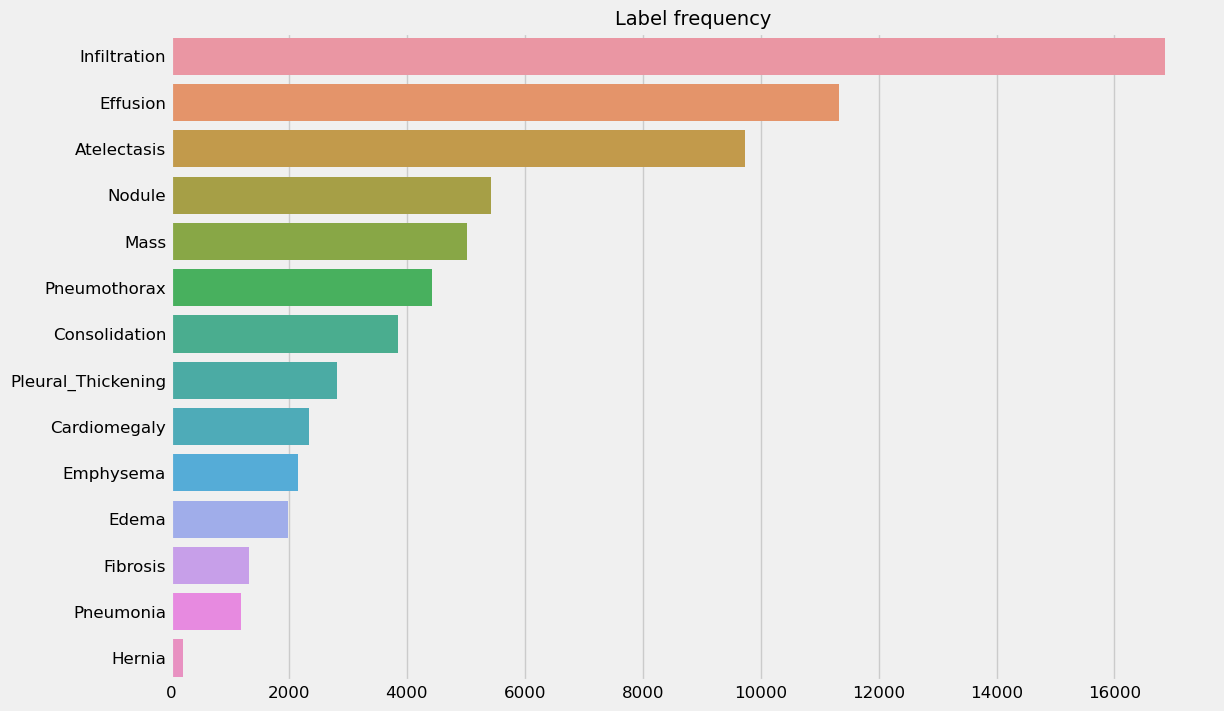

We will be ignoring these rare labels: []


/tmp/ipykernel_896435/1668766392.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_['Finding Labels'] = metadata_['Finding Labels'].apply(lambda s: [l for l in str(s).split('|') if l not in rare])


,Image Index,Finding Labels,Follow-up,Patient ID,Patient Age,Patient Gender,View,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingx,OriginalImagePixelSpacingy
0,00000001_000.png,[Cardiomegaly],0.0,1.0,57.0,M,PA,2682.0,2749.0,0.143,0.143
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1.0,1.0,58.0,M,PA,2894.0,2729.0,0.143,0.143
2,00000001_002.png,"[Cardiomegaly, Effusion]",2.0,1.0,58.0,M,PA,2500.0,2048.0,0.168,0.168
4,00000003_001.png,[Hernia],0.0,3.0,74.0,F,PA,2500.0,2048.0,0.168,0.168
5,00000003_002.png,[Hernia],1.0,3.0,75.0,F,PA,2048.0,2500.0,0.168,0.168


In [12]:
# Get label frequencies in descending order
label_freq = metadata_['Finding Labels'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")odel

plt.figure(figsize=(12,8))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Create a list of rare labels
rare = list(label_freq[label_freq<100].index)
print("We will be ignoring these rare labels:", rare)

# Transform Genre into a list of labels and remove the rare ones
metadata_['Finding Labels'] = metadata_['Finding Labels'].apply(lambda s: [l for l in str(s).split('|') if l not in rare])
metadata_.head()

In [13]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


*Splitting of data*

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

X_train, X_val, y_train, y_val = train_test_split(metadata_['Image Index'], metadata_['Finding Labels'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  34761
Number of posters for validation:  8691


In [15]:
img_folder = '/home/dell15/raw_image_data/imagesall/All_images'
len(os.listdir(img_folder))

92311

In [16]:
X_train = [os.path.join(img_folder, str(f)) for f in X_train]
X_val = [os.path.join(img_folder, str(f)) for f in X_val]
print(X_train[:3])

y_train = list(y_train)
y_val = list(y_val)
print(y_train[:3])

['/home/dell15/raw_image_data/imagesall/All_images/00004554_001.png', '/home/dell15/raw_image_data/imagesall/All_images/00004006_028.png', '/home/dell15/raw_image_data/imagesall/All_images/00019176_052.png']
[['Cardiomegaly'], ['Infiltration'], ['Consolidation', 'Infiltration', 'Pneumonia']]


In [17]:
len(X_train)

34761

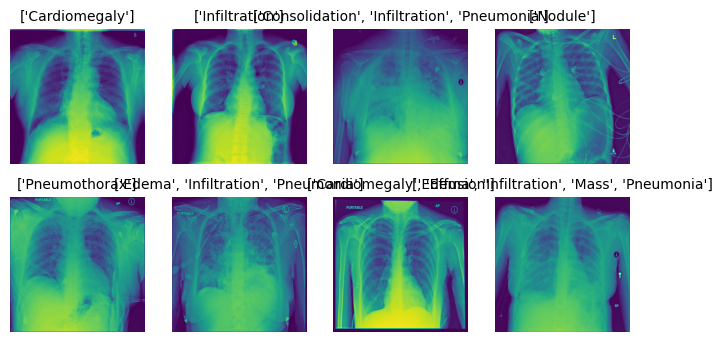

In [18]:
from PIL import Image
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(8,2*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

In [19]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. Atelectasis
1. Cardiomegaly
2. Consolidation
3. Edema
4. Effusion
5. Emphysema
6. Fibrosis
7. Hernia
8. Infiltration
9. Mass
10. Nodule
11. Pleural_Thickening
12. Pneumonia
13. Pneumothorax


In [20]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

# Print example of Xray images and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])

/home/dell15/raw_image_data/imagesall/All_images/00004554_001.png [0 1 0 0 0 0 0 0 0 0 0 0 0 0]
/home/dell15/raw_image_data/imagesall/All_images/00004006_028.png [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
/home/dell15/raw_image_data/imagesall/All_images/00019176_052.png [0 0 1 0 0 0 0 0 1 0 0 0 1 0]


In [21]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
print(IMG_SIZE, CHANNELS, N_LABELS)

def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label



BATCH_SIZE = 64 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

224 3 14


2022-11-28 00:38:20.529688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 00:38:20.999858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6232 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


In [22]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>

In [23]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [24]:
import tensorflow_hub as hub

In [25]:
import keras

*Model without Attention*

In [144]:
vision_model = tf.keras.applications.DenseNet121(
    input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS),
    include_top = False, 
     weights='imagenet')
feature_extractor_layer = tf.keras.Sequential([
    hub.KerasLayer(vision_model, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
])
feature_extractor_layer.trainable = False 

# vision_model = tf.keras.applications.DenseNet121(
#     input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS),
#     include_top = False, 
#      weights='imagenet')
# feature_extractor_layer = tf.keras.Sequential([
#     hub.KerasLayer(vision_model, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
# ])
# feature_extractor_layer.trainable = False

*Augmentation of Data*

In [63]:
data_augmentation = keras.Sequential( 
    [ 
    layers.experimental.preprocessing.Resizing(height=IMG_SIZE, width=IMG_SIZE),
    layers.experimental.preprocessing.RandomRotation(factor=0.1, fill_mode='reflect', interpolation='bilinear', seed=None, fill_value=0.0), 
    layers.experimental.preprocessing.RandomContrast(factor=0.1),
    layers.experimental.preprocessing.Resizing(height=IMG_SIZE, width=IMG_SIZE)


    ])


In [24]:
# batch_size = 64
# AUTOTUNE = tf.data.AUTOTUNE

# resize_and_rescale = tf.keras.Sequential([
#   layers.Resizing(IMG_SIZE, IMG_SIZE),
#   layers.Rescaling(1./255)
# ]) 

# def prepare(ds, shuffle=False, augment=False):
#   # Resize and rescale all datasets.
#   ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
#               num_parallel_calls=AUTOTUNE)

#   if shuffle:
#     ds = ds.shuffle(1000)

#   # Batch all datasets.
#   # ds = ds.batch(batch_size)

#   # Use data augmentation only on the training set.
#   if augment:
#     ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
#                 num_parallel_calls=AUTOTUNE)

#   # Use buffered prefetching on all datasets.
#   return ds#.prefetch(buffer_size=AUTOTUNE)

# train_ds = prepare(train_ds, shuffle=True, augment=True)
# val_ds = prepare(val_ds)

#     dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
#     # Parse and preprocess observations in parallel
#     dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
#     if is_training == True:
#         # This is a small dataset, only load it once, and keep it in memory.
#         dataset = dataset.cache()
#         # Shuffle the data each buffer size
#         dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
#     # Batch the data for multiple steps
#     dataset = dataset.batch(BATCH_SIZE)
#     # Fetch batches in the background while the model is training.
#     dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
#     return dataset

# train_ds = create_dataset(X_train, y_train_bin)
# val_ds = create_dataset(X_val, y_val_bin)

In [36]:
# feature_extractor_layer.get_output_at(0)

RuntimeError: The layer sequential has never been called and thus has no defined output.

*Withiout attention implementation*

In [64]:
simple_cnn_no_attention = tf.keras.models.Sequential([
    tf.keras.Input((IMG_SIZE, IMG_SIZE, CHANNELS)),
    data_augmentation,
    feature_extractor_layer,
    # tf.keras.layers.Flatten(),

    # tf.keras.layers.Dense(N_LABELS , activation='softmax'),
    tf.keras.layers.Conv2D(32, 3, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS), activation='elu', padding='same'),   
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(N_LABELS, activation='softmax'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(N_LABELS , activation='softmax'),
])
simple_cnn_no_attention.summary()



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 sequential_9 (Sequential)   (None, 7, 7, 2048)        58370944  
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 7, 32)          589856    
                                                                 
 conv2d_20 (Conv2D)          (None, 7, 7, 32)          9248      
                                                                 
 batch_normalization_14 (Bat  (None, 7, 7, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 32)          9248      
                                                     

In [30]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 acrotrain_dsss labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [24]:
train_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>

In [29]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 50

# simple_cnn_no_attention.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
#                                 loss=tf.keras.metrics.CategoricalCrossentropy(),
#                                 metrics=['accuracy', 
#                                         tf.keras.metrics.AUC(curve='PR'),
#                                         tf.keras.metrics.AUC(curve='PR')])

# simple_cnn_no_attention.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
#                                 loss=tf.keras.metrics.CategoricalCrossentropy(),
#                                 metrics=['accuracy'])
# simple_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
#                                 loss=tf.keras.metrics.CategoricalCrossentropy(),
#                                 metrics=['accuracy'])

simple_cnn_no_attention.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy',tf.keras.metrics.AUC(curve='PR'),tf.keras.metrics.AUC(curve='PR')],
)
# history = simple_model.fit(train_ds, epochs=2)
history = simple_cnn_no_attention.fit(train_ds, epochs=50)

Epoch 1/5


2022-11-28 00:38:50.998408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


508/544 [===========================>..] - ETA: 22s - loss: 3.9483 - accuracy: 0.2091 - auc: 0.2553 - auc_1: 0.2553

2022-11-28 00:44:16.930175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


544/544 [==============================] - 354s 631ms/step - loss: 3.9617 - accuracy: 0.2089 - auc: 0.2550 - auc_1: 0.2550
Epoch 2/5
291/544 [===============>..............] - ETA: 1:21 - loss: 4.4590 - accuracy: 0.1918 - auc: 0.2473 - auc_1: 0.2473

KeyboardInterrupt: 

In [39]:
y_pred = simple_cnn_no_attention.predict(val_ds)

2022-11-27 23:40:54.586532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 962 of 1024
2022-11-27 23:40:55.361270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


136/136 [==============================] - 104s 674ms/step


In [42]:
class_accuracies = []
for class_ in np.unique(y_val_bin):
    class_acc = np.mean(y_pred[y_val_bin == class_] == class_)
    class_accuracies.append(class_acc)
class_accuracies

[0.08010187543412826, 0.0]

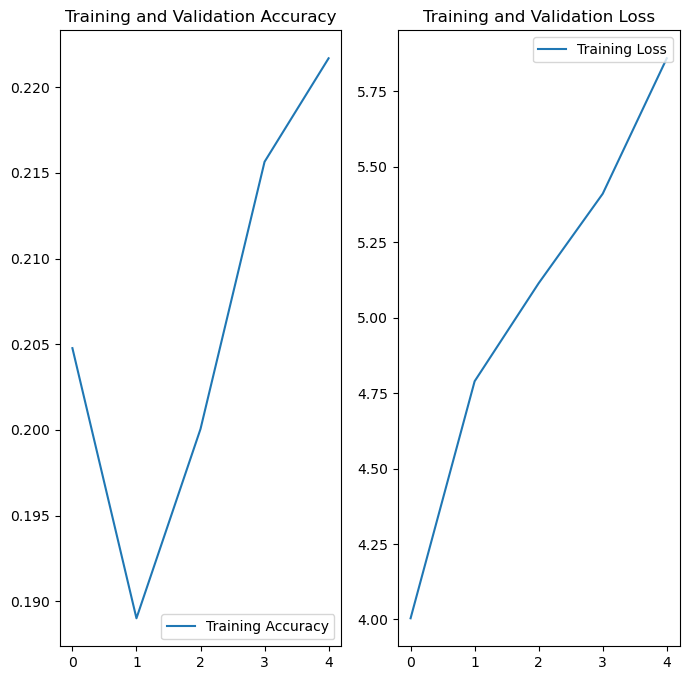

In [35]:
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*With Attention*

In [33]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            
            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = self.shared_layer_one(max_pool)
            max_pool = self.shared_layer_two(max_pool)

            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)
            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
            attention = self.conv2d(attention)
            return tf.keras.layers.multiply([inputs, attention]) 

simple_cnn_with_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS), activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(N_LABELS, activation='softmax' )
])

In [34]:
LR = 0.001 # Keep it small when transfer learning
simple_cnn_with_attention.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                                loss=macro_soft_f1,
                                metrics=['accuracy', macro_f1])


history_attn = simple_cnn_with_attention.fit(train_ds, epochs=2)

Epoch 1/2
544/544 [==============================] - 109s 195ms/step - loss: 0.9128 - accuracy: 0.1757 - macro_f1: 0.0716
Epoch 2/2
544/544 [==============================] - 106s 194ms/step - loss: 0.9056 - accuracy: 0.1835 - macro_f1: 0.0891


In [36]:
pip install tf-explain

     |████████████████████████████████| 43 kB 99 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [37]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
for images, labels in val_ds.take(1):
    X_test = imagesvision_model = tf.keras.applications.DenseNet121(
    input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS),
    include_top = False, 
     weights='imagenet')
feature_extractor_layer = tf.keras.Sequential([
    hub.KerasLayer(vision_model, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
])
feature_extractor_layer.trainable = False
    y_test = labels
    break

ImportError: TF-explain requires Opencv. Install Opencv via `pip install opencv-python`

In [32]:
plt.imshow(X_test[10])
img = tf.Variable(X_test[0])
# img = tf.cast(X_test[10], 'uint8')
plt.imshow(img)

NameError: name 'X_test' is not defined

In [26]:
print(X_test.shape, y_test.shape)

(64, 224, 224, 3) (64, 13)


In [65]:
tf.expand_dims(X_train[0], axis=0).shape

TensorShape([1])

In [66]:
X_train[0]

'/storage_nvme2/yogesh/JKD/data_xray/images/00009021_014.png'

In [80]:
simple_cnn_no_attention(tf.expand_dims(X_test[0], axis=0))

<tf.Tensor: shape=(1, 13), dtype=float32, numpy=
array([[3.0452812e-03, 3.4745797e-03, 4.9001202e-02, 9.2080021e-01,
        2.0659436e-05, 3.4496460e-07, 6.2358808e-08, 2.2396358e-02,
        3.4248970e-07, 2.9267025e-07, 5.6687072e-06, 1.2549105e-03,
        3.3773826e-09]], dtype=float32)>

In [55]:
X_test[0].dtype

tf.float32

In [88]:
#img = X_test[0]
img = tf.Variable(X_test[0])
y = y_test[0]
#img = tf.cast(X_test[0], 'uint225', name=None)

data = ([img], None)
predictions = simple_cnn_no_attention(tf.expand_dims(X_test[0], axis=0))
y_predm_1 = np.argmax(predictions)

grid_1 = explainer.explain(data, simple_cnn_no_attention, class_index=y_predm_1, image_weight=0.8)


AttributeError: 'ResourceVariable' object has no attribute 'min'

In [38]:
# With and wothout attention
from visualize import explainGradCam
fig, axes = plt.subplots(1, 2, figsize=(8,4))
fig.tight_layout()
index = 0
for img, label in zip(X_test, y_test):
    explainGradCam(explainer, axes[index], img,
               label,
               simple_cnn_no_attention,
               simple_cnn_no_attention.predict(img), 
               simple_cnn_with_attention,
               simple_cnn_with_attention.predict(img), 
               class_names=mlb.classes_)
    index += 1
    break

ModuleNotFoundError: No module named 'visualize'

In [34]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 13)


*With attention Implementation of Densenet*

In [156]:
data_augmentation = keras.Sequential( 
    [ 
    layers.experimental.preprocessing.Resizing(height=IMG_SIZE, width=IMG_SIZE),
    layers.experimental.preprocessing.RandomRotation(factor=0.1, fill_mode='reflect', interpolation='bilinear', seed=None, fill_value=0.0), 
    layers.experimental.preprocessing.RandomContrast(factor=0.1),
    layers.experimental.preprocessing.Resizing(height=IMG_SIZE, width=IMG_SIZE)


    ])

In [157]:
# import tensorflow_hub as hub

# mobilenet_v2 = tf.keras.models.load_model('pretrained_models/imagenet_mobilenet_v2_100_224_classification_5')
# feature_extractor_layer = tf.keras.Sequential([
#     hub.KerasLayer(mobilenet_v2, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
# ])

# feature_extractor_layer.trainable = False

# model = tf.keras.Sequential([
#     feature_extractor_layer,
#     layers.Dense(1024, activation='relu', name='hidden_layer'),
#     layers.Dense(N_LABELS, activation='sigmoid', name='output')
# ])

# model.summary()
vision_model = tf.keras.applications.DenseNet121(
    input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS),
    include_top = False, 
     weights='imagenet')
feature_extractor_layer = tf.keras.Sequential([
    hub.KerasLayer(vision_model, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
])
feature_extractor_layer.trainable = False 

model = tf.keras.Sequential([
    data_augmentation,
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    tf.keras.layers.Conv2D(32, 3, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS), activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(N_LABELS, activation='softmax' ),
    # tf.keras.layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

In [150]:
for batch in train_ds:
    print(model.predict(batch)[:1])
    break

ValueError: in user code:

    File "/home/dell15/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/home/dell15/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dell15/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/home/dell15/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/home/dell15/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/dell15/miniconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential_16" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32, 14) dtype=int64>]


In [151]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

*Prediction of Individual Accuracies*

In [ ]:
y_pred = simple_cnn_no_attention.predict(val_ds)

class_accuracies = []
for class_ in np.unique(y_val_bin):
    class_acc = np.mean(y_pred[y_val_bin == class_] == class_)
    class_accuracies.append(class_acc)
class_accuracies

In [ ]:
y_pred[y_pred>0.5]=1
y_pred[y_pred<0.5]=0
y_pred

In [136]:
y_pred = model.predict(val_ds)
y_pred

136/136 [==============================] - 6s 47ms/step


array([[8.50139260e-02, 1.04019591e-05, 9.82718647e-01, ...,
        3.48742791e-02, 3.15906584e-01, 1.50577351e-02],
       [9.98077750e-01, 3.42480140e-04, 8.60498965e-01, ...,
        1.41511168e-02, 1.68838501e-01, 5.32640342e-06],
       [2.61152200e-05, 4.62456256e-01, 5.11619801e-05, ...,
        4.85976040e-02, 9.99024720e-04, 1.36034878e-03],
       ...,
       [6.97327137e-01, 1.29078644e-05, 8.47675401e-05, ...,
        4.22451615e-01, 3.36509140e-04, 1.44610752e-03],
       [2.32099657e-04, 5.03856015e-08, 7.85759403e-05, ...,
        9.89727080e-01, 1.00736004e-04, 6.22018158e-01],
       [9.78673995e-01, 5.25430078e-04, 4.23110236e-04, ...,
        3.70535872e-06, 3.54533317e-04, 3.00465963e-05]], dtype=float32)

In [140]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
for i in range(14):
    print(average_precision_score(y_val_bin[:, i], y_pred[:, i]))
    print(roc_auc_score(y_val_bin[:, i], y_pred[:, i]))
    print()

0.22736056492784962
0.49536700065016925

0.05515249948353476
0.5064578817993034

0.08544417006344283
0.49594049447231303

0.045452346411509505
0.4972118778468122

0.256048039758461
0.4997925799922035

0.05022622341497812
0.5016756883186314

0.029501457334553838
0.4987326635103975

0.004832585433206766
0.49537518788299223

0.3891381889310781
0.5

0.11833704174585978
0.5055293649535777

0.12757453641990757
0.5130424885988453

0.06315519695609001
0.49584129018552925

0.023837413318818258
0.5027235383972859

0.10146347251123056
0.49369766036432705



In [142]:
y_pred.shape

(8691, 14)

In [141]:
accuracies = []
for i in range(14):
    confusion = collections.Counter(y_pred[:, i]==y_val_bin[:, i])
    acc = confusion[True]/len(y_pred)*100
    accuracies.append(acc)
    i+=1
accuracies

[50.293406972730416,
 90.6915199631803,
 67.85180071338166,
 88.03359797491657,
 50.385456219077206,
 92.00322172362215,
 92.03774019100219,
 98.59624899321136,
 38.91381889310781,
 74.44482798297088,
 67.34552985847428,
 78.02324243470257,
 90.30031066620641,
 79.4269934414912]

In [130]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
for i in range(14):
    print(average_precision_score(y_val_bin[:, i], y_pred[:, i]))
    print(roc_auc_score(y_val_bin[:, i], y_pred[:, i]))
    print()

0.22433646852627404
0.49547543717693077

0.05837434748910812
0.5195759979460572

0.08643950006892784
0.502519034349688

0.044534369686667144
0.487091667127279

0.257663758093739
0.49809253503383

0.053051834530432496
0.49424605163503516

0.02953762852735039
0.47968801469685884

0.005608664951661016
0.4838035225652291

0.3977107943046757
0.5088005383224474

0.11255358613952973
0.4818250636208869

0.11766180735822254
0.48149755287845

0.06874276431674964
0.5125623456496591

0.022285272216994122
0.4815768546435457

0.1073678233182875
0.5040151515151515



In [120]:
y_pred1=y_pred

In [135]:
y_val_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [139]:
y_pred

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [107]:
for i in range(14):
    for j in range(5691):
        if(y_cal[i][j]=='true'):
            y_cal[i][j]=1

# y_cal = int(y_cal=='true')



IndexError: index 14 is out of bounds for axis 0 with size 14

In [117]:
import collections
confusion = collections.Counter(y_pred[:, 0]==y_val_bin[:, 0])
acc = confusion[True]/len(y_pred)*100
acc

77.1027499712346

In [137]:
#new
import collections
confusion = collections.Counter(y_pred[:, 0]==y_val_bin[:, 0])
acc = confusion[True]/len(y_pred)*100
acc

0.011506155793349442

In [118]:
accuracies = []
for i in range(14):
    confusion = collections.Counter(y_pred[:, i]==y_val_bin[:, i])
    acc = confusion[True]/len(y_pred)*100
    accuracies.append(acc)
    i+=1
accuracies

[77.1027499712346,
 94.56909446553907,
 91.39339546657462,
 95.43205615004027,
 74.38729720400414,
 94.99482222989299,
 97.0429179611092,
 99.51674145667933,
 61.08618110689219,
 88.28673340237026,
 87.5503394315959,
 93.63709584627776,
 97.62973190657002,
 89.74801518812565]

In [95]:
y_val_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [84]:
a = np.zeros(14)
a[y_pred[0]>0.5]=1
a


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [85]:
[a==y_train_bin[0]]

[array([ True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True])]

In [ ]:
LR = 1e-5 # Keep it small when acctransfer learning
EPOCHS = 50

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=['accuracy', macro_f1, tf.keras.metrics.AUC(curve='PR'),tf.keras.metrics.AUC(curve='PR')])

from datetime import time
start = time()
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(time()-start)))

History keys: dict_keys(['loss', 'accuracy', 'macro_f1', 'auc_2', 'auc_3', 'val_loss', 'val_accuracy', 'val_macro_f1', 'val_auc_2', 'val_auc_3'])


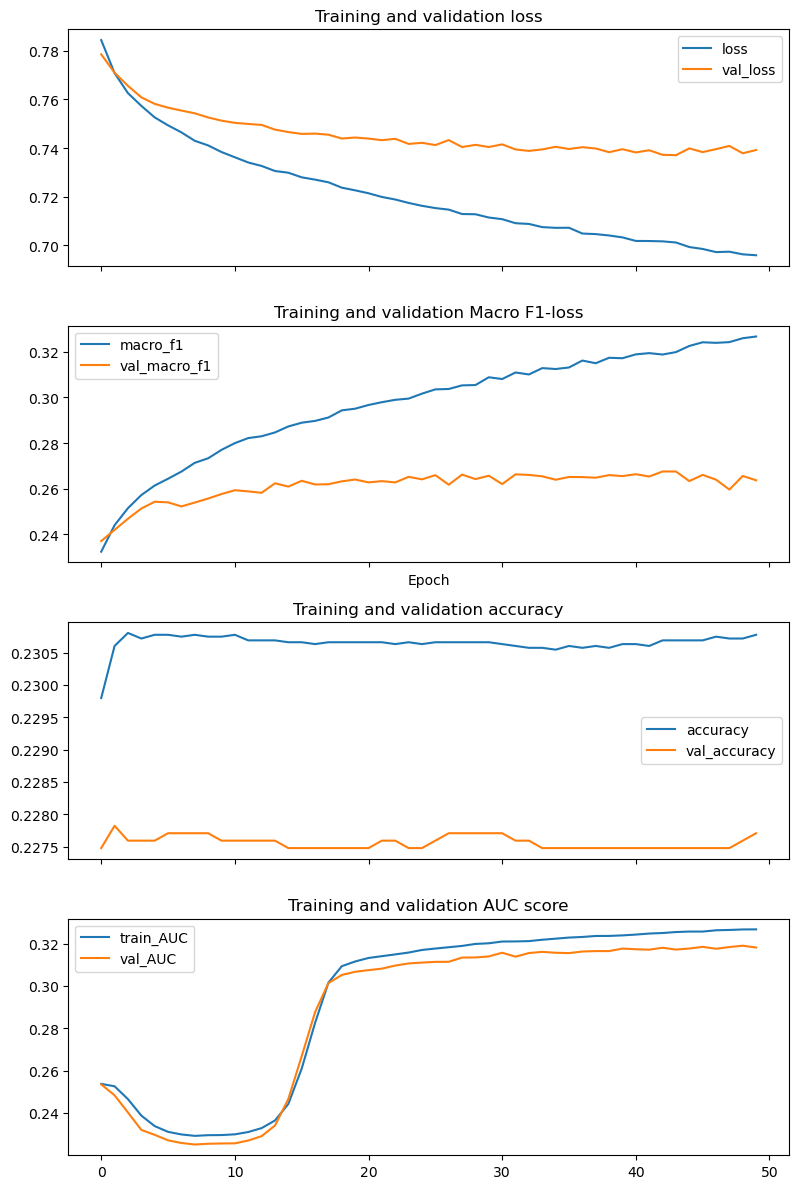

In [59]:
import matplotlib.pyplot as plt
print('History keys:', history.history.keys())
fig, ax = plt.subplots(4, figsize=(8,12), sharex=True)

   
ax[0].plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
ax[0].plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
ax[0].set_title('Training and validation loss')

ax[1].plot(range(len(history.history['macro_f1'])),history.history['macro_f1'], label='macro_f1')
ax[1].plot(range(len(history.history['val_macro_f1'])),history.history['val_macro_f1'], label='val_macro_f1')
ax[1].set_title('Training and validation Macro F1-loss')
ax[1].set_xlabel('Epoch')

ax[2].plot(range(len(history.history['accuracy'])),history.history['accuracy'], label='accuracy')
ax[2].plot(range(len(history.history['val_accuracy'])),history.history['val_accuracy'], label='val_accuracy')
ax[2].set_title('Training and validation accuracy')

ax[3].plot(range(len(history.history['auc_2'])),history.history['auc_2'], label='train_AUC')
ax[3].plot(range(len(history.history['val_auc_2'])),history.history['val_auc_2'], label='val_AUC')
ax[3].set_title('Training and validation AUC score')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.tight_layout()

History keys: dict_keys(['loss', 'accuracy', 'macro_f1', 'auc_2', 'auc_3', 'val_loss', 'val_accuracy', 'val_macro_f1', 'val_auc_2', 'val_auc_3'])


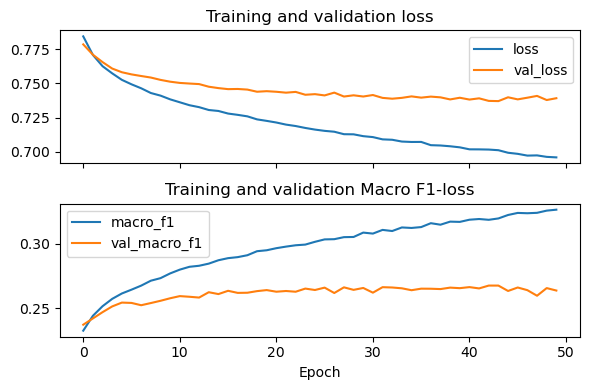

In [46]:
import matplotlib.pyplot as plt
print('History keys:', history.history.keys())
fig, ax = plt.subplots(2, figsize=(6,4), sharex=True)
   
ax[0].plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
ax[0].plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
ax[0].set_title('Training and validation loss')

ax[1].plot(range(len(history.history['macro_f1'])),history.history['macro_f1'], label='macro_f1')
ax[1].plot(range(len(history.history['val_macro_f1'])),history.history['val_macro_f1'], label='val_macro_f1')
ax[1].set_title('Training and validation Macro F1-loss')
ax[1].set_xlabel('Epoch')

ax[0].legend()
ax[1].legend()
plt.tight_layout()

In [42]:
# Train model with BCE
from utils import *
model_bce = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(N_LABELS, activation='sigmoid')
])

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_bce = model_bce.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(time()-start)))

/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
150/150 [==============================] - 28s 179ms/step - loss: 0.3717 - macro_f1: 0.0708 - val_loss: 0.3246 - val_macro_f1: 0.0691
Epoch 2/50
150/150 [==============================] - 23s 152ms/step - loss: 0.3178 - macro_f1: 0.0694 - val_loss: 0.3133 - val_macro_f1: 0.0668
Epoch 3/50
150/150 [==============================] - 23s 153ms/step - loss: 0.3099 - macro_f1: 0.0765 - val_loss: 0.3084 - val_macro_f1: 0.0785
Epoch 4/50
150/150 [==============================] - 22s 144ms/step - loss: 0.3057 - macro_f1: 0.0806 - val_loss: 0.3058 - val_macro_f1: 0.0807
Epoch 5/50
150/150 [==============================] - 22s 146ms/step - loss: 0.3031 - macro_f1: 0.0838 - val_loss: 0.3038 - val_macro_f1: 0.0819
Epoch 6/50
150/150 [==============================] - 21s 141ms/step - loss: 0.3013 - macro_f1: 0.0860 - val_loss: 0.3028 - val_macro_f1: 0.0857
Epoch 7/50
150/150 [==============================] - 22s 148ms/step - loss: 0.3000 - macro_f1: 0.0890 - val_loss: 0.3022 - val_ma

History keys: dict_keys(['loss', 'macro_f1', 'val_loss', 'val_macro_f1'])


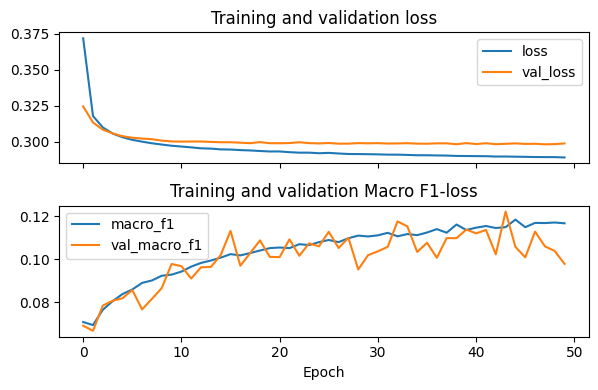

In [44]:
import matplotlib.pyplot as plt
print('History keys:', history_bce.history.keys())
fig, ax = plt.subplots(2, figsize=(6,4), sharex=True)
   
ax[0].plot(range(len(history_bce.history['loss'])),history_bce.history['loss'], label='loss')
ax[0].plot(range(len(history_bce.history['val_loss'])),history_bce.history['val_loss'], label='val_loss')
ax[0].set_title('Training and validation loss')

ax[1].plot(range(len(history_bce.history['macro_f1'])),history_bce.history['macro_f1'], label='macro_f1')
ax[1].plot(range(len(history_bce.history['val_macro_f1'])),history_bce.history['val_macro_f1'], label='val_macro_f1')
ax[1].set_title('Training and validation Macro F1-loss')
ax[1].set_xlabel('Epoch')

ax[0].legend()
ax[1].legend()
plt.tight_layout()

In [45]:
from utils import perf_grid
# Get all label names
label_names = mlb.classes_
# Performance table with the first model (macro soft-f1 loss)
grid = perf_grid(val_ds, y_val_bin, label_names, model)
# Performance table with the second model (binary cross-entropy loss)
grid_bce = perf_grid(val_ds, y_val_bin, label_names, model_bce)

In [46]:
grid_bce.head()

,id,label,freq,threshold,tp,fn,fp,precision,recall,f1
0,0,Atelectasis,0.22,0.00,2106,0,7446,0.220477,1.000000,0.361297
1,0,Atelectasis,0.22,0.01,2106,0,7442,0.220570,1.000000,0.361421
2,0,Atelectasis,0.22,0.02,2088,18,7381,0.220509,0.991453,0.360778
3,0,Atelectasis,0.22,0.03,2054,52,7253,0.220694,0.975309,0.359940
4,0,Atelectasis,0.22,0.04,2001,105,7066,0.220690,0.950142,0.358185


In [47]:
# Get the maximum F1-score for each label when using the second model and varying the threshold
max_perf = grid_bce.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max_bce'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max_bce'], cmap=sns.light_palette("lightgreen", as_cmap=True))

,id,label,freq,f1max_bce
0,7,Infiltration,0.380000,0.554370
1,4,Effusion,0.260000,0.418909
2,0,Atelectasis,0.220000,0.361421
3,9,Nodule,0.120000,0.216656
4,8,Mass,0.120000,0.206871
5,12,Pneumothorax,0.110000,0.191765
6,2,Consolidation,0.090000,0.160308
7,10,Pleural_Thickening,0.070000,0.127494
8,1,Cardiomegaly,0.060000,0.107942
9,5,Emphysema,0.050000,0.095694


In [48]:
print("Correlation between label frequency and optimal F1 with bce: %.2f" %max_perf['freq'].corr(max_perf['f1max_bce']))

Correlation between label frequency and optimal F1 with bce: 1.00


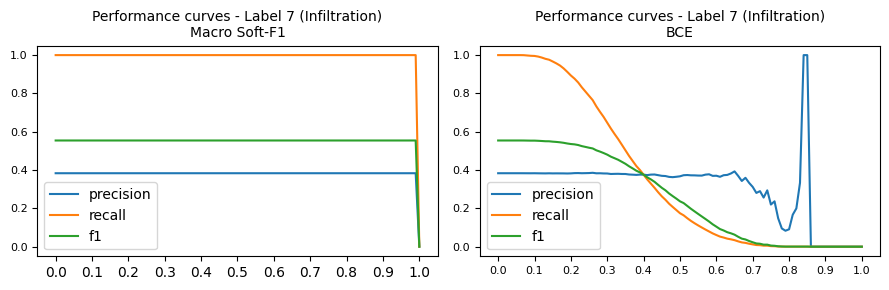

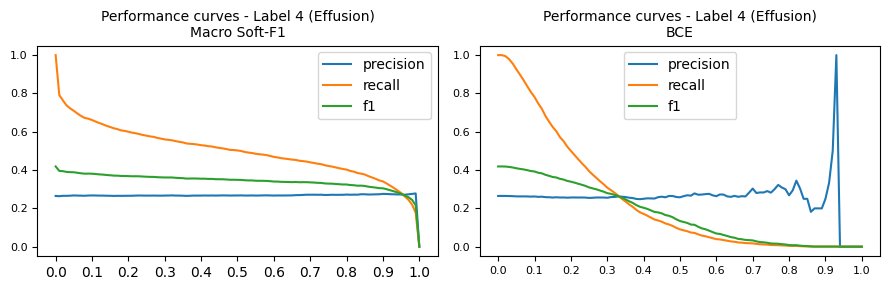

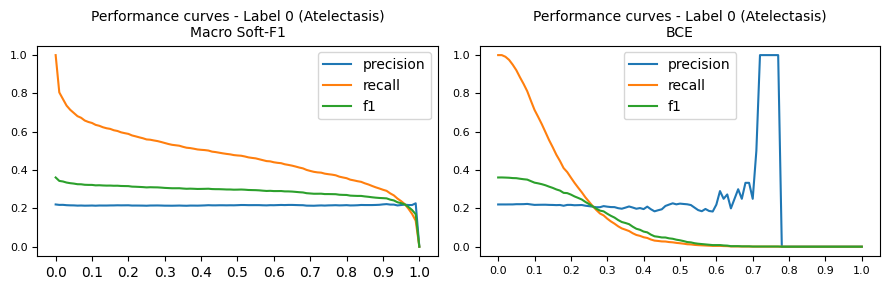

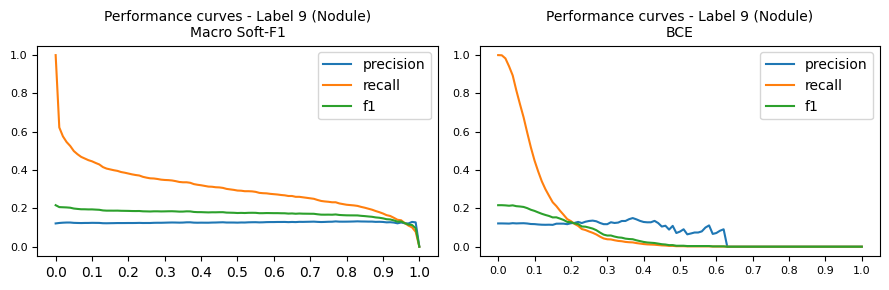

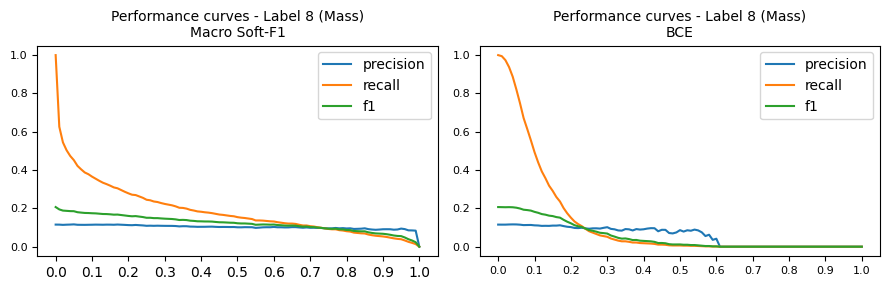

In [49]:
top5 = max_perf.head(5)['id']
style.use("default")
for l in top5:
    
    label_grid = grid.loc[grid['id']==l, ['precision','recall','f1']]
    label_grid = label_grid.reset_index().drop('index', axis=1)
    
    label_grid_bce = grid_bce.loc[grid_bce['id']==l, ['precision','recall','f1']]
    label_grid_bce = label_grid_bce.reset_index().drop('index', axis=1)
    
    plt.figure(figsize=(9,3))

    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=10)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    label_grid.plot(ax=ax)
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    label_grid_bce.plot(ax=ax)
    
    plt.tight_layout()
    plt.show()


/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


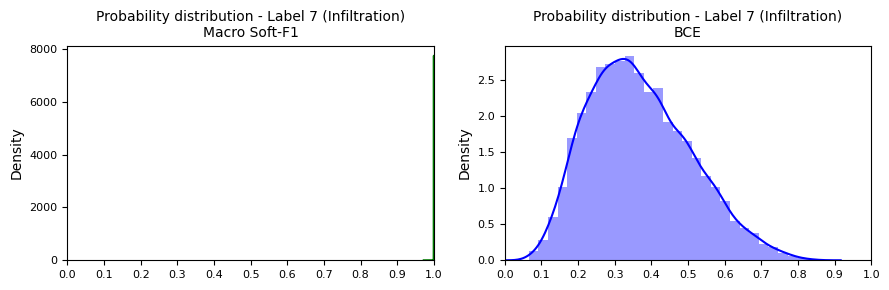

/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


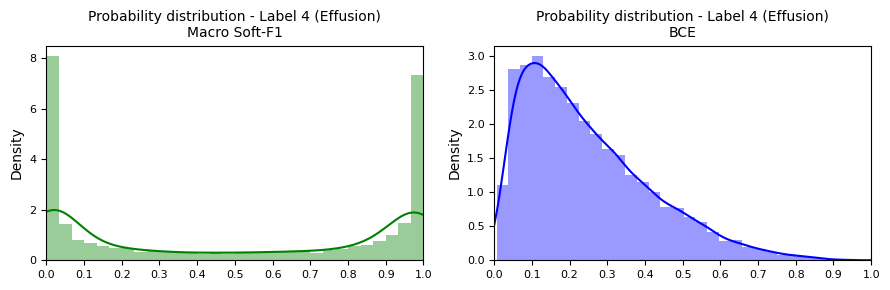

/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


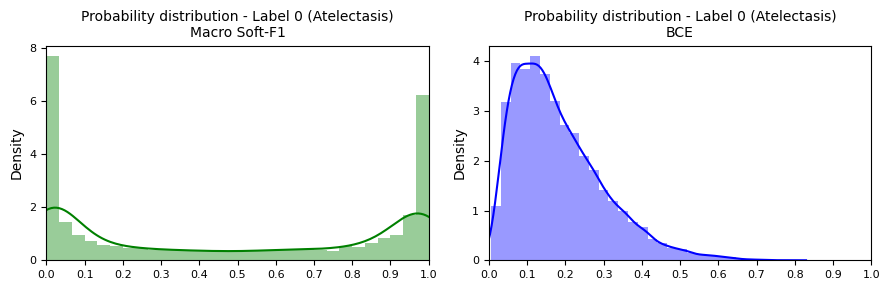

/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


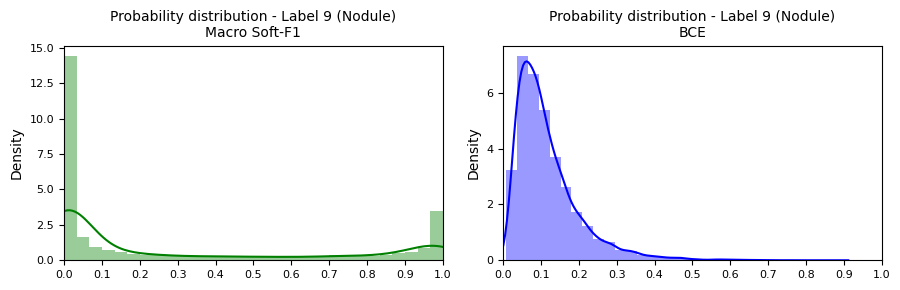

/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


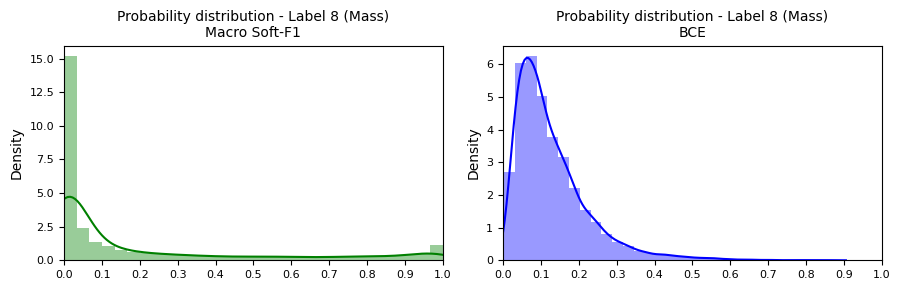

In [50]:
# Probability distribution
# Predict on the validation set with both models
y_hat_val = model.predict(val_ds)
y_hat_val_bce = model_bce.predict(val_ds)

style.use("default")
for l in top5:
    plt.figure(figsize=(9,3))
    
    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val[:,l], bins=30, kde=True, color="g")
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val_bce[:,l], bins=30, kde=True, color="b")
    
    plt.tight_layout()
    plt.show()
    

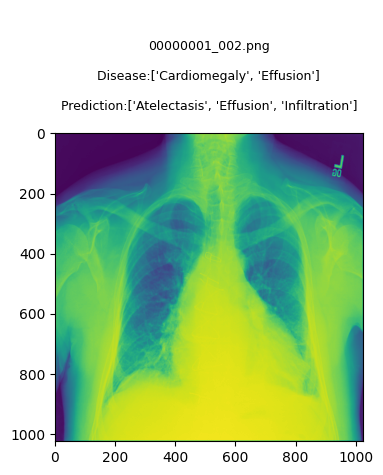

In [51]:
#def show_prediction(image_id, metadata_, model):
    #print(image_id, metadata_df)
    # Get movie info
    
from keras.preprocessing import image
img_id = '00000001_002.png'

true_label = metadata_.loc[metadata_['Image Index']==img_id]['Finding Labels'].iloc[0]
img_path = os.path.join(img_folder, str(img_id))

# Read and prepare image
img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
img = image.img_to_array(img)
img = img/255
img = np.expand_dims(img, axis=0)

# Generate prediction
prediction = (model.predict(img) > 0.5).astype('int')
prediction = pd.Series(prediction[0])
prediction.index = mlb.classes_
prediction = prediction[prediction==1].index.values

# Dispaly image with prediction
style.use('default')
plt.figure(figsize=(8,4))
plt.imshow(Image.open(img_path))
plt.title('\n\n{}\n\nDisease:{}\n\nPrediction:{}\n'.format(img_id, true_label, list(prediction)), fontsize=9)
plt.show()